**Lab 9, Filip Gacek - Anomaly Detection**

#**Anomaly Detection**


Loading data.

In [49]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from scipy.io import loadmat  
 
 
data = loadmat('ex8data1.mat')
X = data['X']
print(f"Shape of dataset{X.shape}")
df = pd.DataFrame(X)
df.describe()

Shape of dataset(307, 2)


,0,1
count,307.000000,307.000000
mean,14.112226,14.997711
std,1.355957,1.309707
min,4.752613,4.126232
25%,13.403351,14.361997
50%,14.059507,15.023113
75%,14.675503,15.654394
max,23.339868,24.350407


In [50]:
df.head()

,0,1
0,13.046815,14.741152
1,13.408520,13.763270
2,14.195915,15.853181
3,14.914701,16.174260
4,13.576700,14.042849


Visualizing data

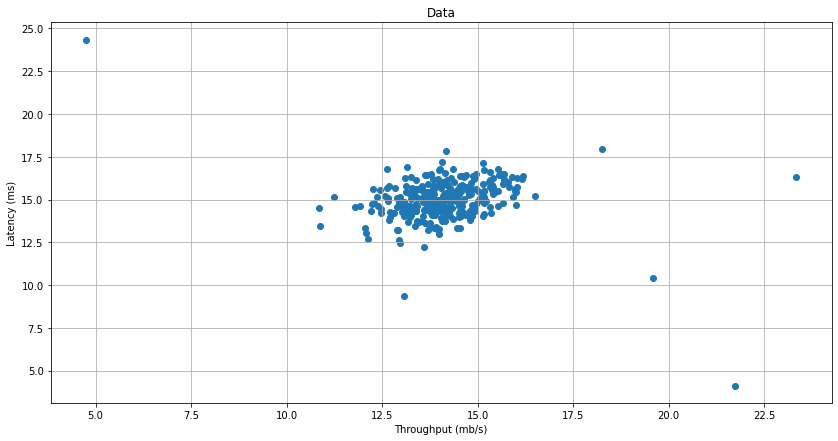

In [51]:
plt.figure(num=1, figsize=[14,7])
plt.title("Data")
plt.scatter(df.iloc[:,0], df.iloc[:, 1])
plt.xlabel("Throughput (mb/s)")
plt.ylabel("Latency (ms)")
plt.grid()

We can see on the plot that there are few objects that don't fit to the rest of data. We can classify them as a anomaly.

Checking neccesity of scaling

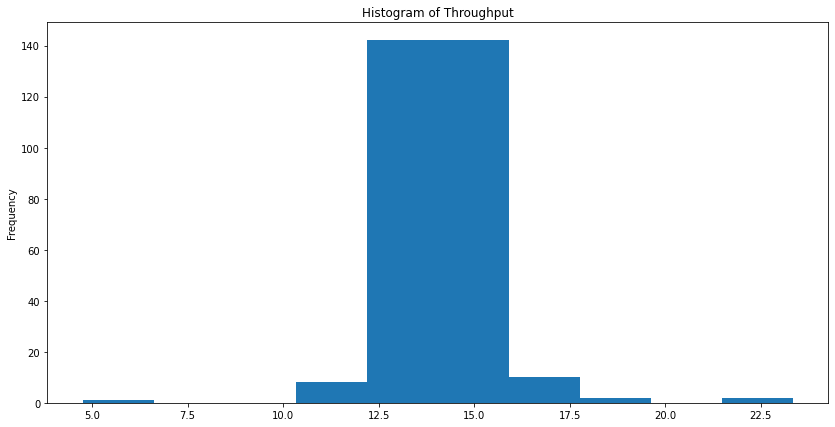

In [52]:
df[0].plot(kind='hist', title="Histogram of Throughput", figsize=[14, 7])

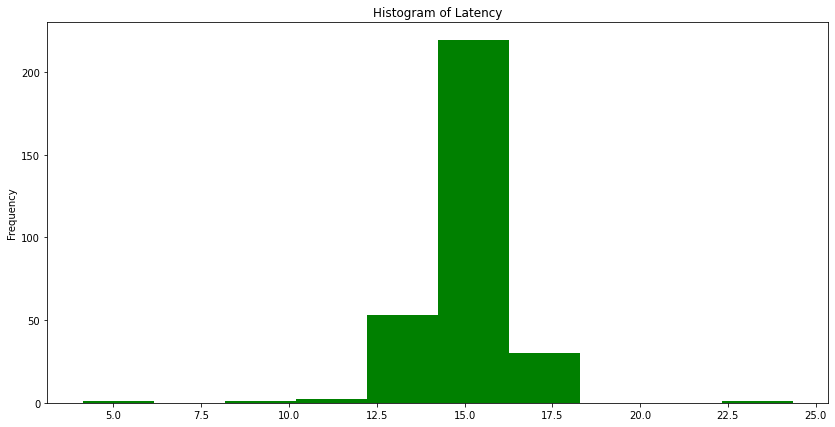

In [53]:
df[1].plot(kind='hist', title="Histogram of Latency", figsize=[14, 7], color='g')

#**Gaussian distribution**

In [54]:
def estimate_gaussian(X):
  return X.mean(), X.std()

mu_throughput, sigma_throughput = estimate_gaussian(df[0])
mu_latency, sigma_latency = estimate_gaussian(df[1])

print(f"MU of Throughput: {mu_throughput} \nSigma of Throughput: {sigma_throughput} \n")
print(f"MU of Latency: {mu_latency} \nSigma of Latency: {sigma_latency}")

MU of Throughput: 14.1122257839456 
Sigma of Throughput: 1.3559573758204513 

MU of Latency: 14.99771050813621 
Sigma of Latency: 1.3097071175918311


#**Calculate probability**

In [55]:
Xval = data['Xval']
yval = data['yval']
print(f"Xval shape: {Xval.shape}")
print(f"yval shape: {yval.shape}")

Xval shape: (307, 2)
yval shape: (307, 1)


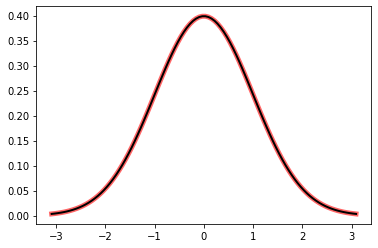

In [56]:
from scipy import stats
stat = stats.norm.pdf(X)
x = np.linspace(stats.norm.ppf(0.001), stats.norm.ppf(0.999), 100)
plt.plot(x, stats.norm.pdf(x), 'r-', lw=5, alpha=0.6, label='norm pdf')
rv = stats.norm()
plt.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

#**Selecting the threshold**


In [59]:
from sklearn.metrics import f1_score

def select_threshold(pval, yval): 
  pred = np.zeros((len(yval),1))
  probability_space = np.array(np.linspace(pval.min(),pval.max(),10000))
  best_epsilon = probability_space[np.random.randint(0, 10000)]
  epsilon = probability_space[0]
  for k in range(len(yval)):
      if pval[k,0] > epsilon or pval[k,1] > epsilon:
          pred[k] = 1
  best_f1 = f1_score(yval, pred)
  for i in range(len(probability_space)):
      epsilon = probability_space[i]
      pred = np.zeros((len(yval),1))
      for j in range(len(yval)):
          if pval[j,0] < epsilon or pval[j,1] < epsilon:
              pred[j] = 1
      f1 = f1_score(yval, pred)
      if f1 > best_f1:
          best_epsilon = epsilon
          best_f1 = f1
  return best_epsilon, best_f1

pval = np.zeros((Xval.shape))  
pval[:,0] = stats.norm.pdf(Xval[:,0], mu_throughput, sigma_throughput)
pval[:,1] = stats.norm.pdf(Xval[:,1], mu_latency, sigma_latency)

best_epsilon, best_f1_score = select_threshold(pval, yval)
print(f"Best epsilon: {best_epsilon}\nBest f1: {best_f1_score}")

Best epsilon: 0.00042648840562710616
Best f1: 0.8750000000000001


#**Anomaly detection results**

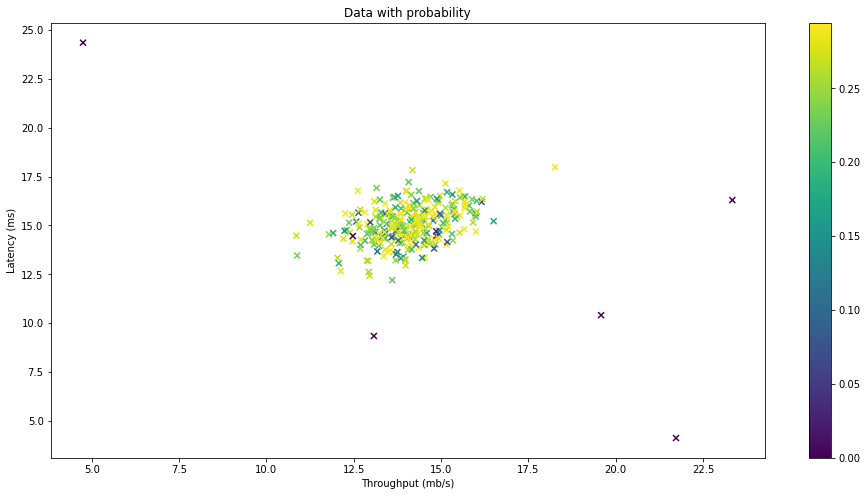

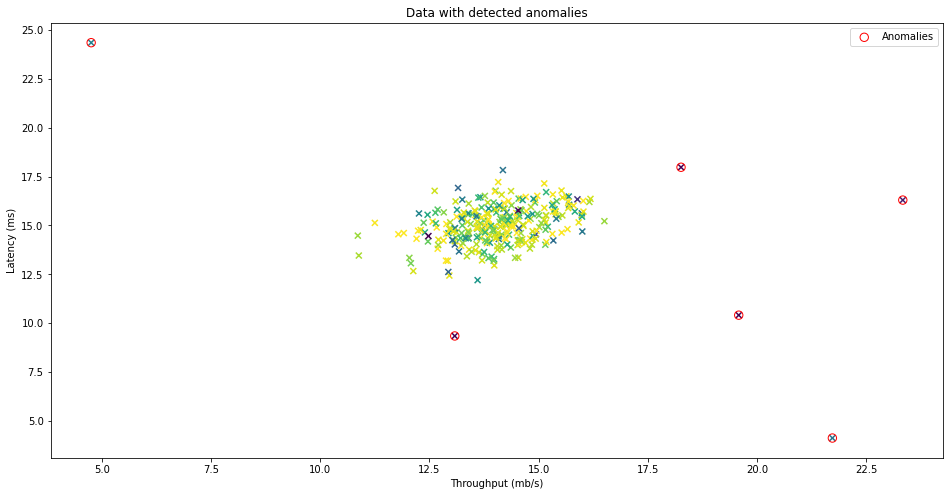

In [58]:
x1, x2 = X[:, 0], X[:, 1]
plt.figure(figsize=[16, 8])
plt.scatter(x1, x2, c=pval[:, 0], cmap='viridis', marker='x')
plt.title("Data with probability")
plt.colorbar()
plt.xlabel("Throughput (mb/s)")
plt.ylabel("Latency (ms)")
plt.show()

epsilon = best_epsilon
plt.figure(figsize=(16,8))
plt.scatter(x1, x2,marker="x",c=pval[:, 1], cmap='viridis');
outliers = np.nonzero(prob<epsilon)[0]
plt.title("Data with detected anomalies")
plt.xlabel("Throughput (mb/s)")
plt.ylabel("Latency (ms)")
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70, label="Anomalies")
plt.legend()

Conclusions: All anomalies are detected. The denisty of probability space may affect on threshold. On the plot we can see that all points from main cluster were classified as normal. We can also see that their probability is much much bigger than anomalies. 